 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/2_classify_newswires.ipynb#Data-preparation" data-toc-modified-id="Data-preparation-1">Data preparation</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/2_classify_newswires.ipynb#Building-the-network" data-toc-modified-id="Building-the-network-2">Building the network</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/2_classify_newswires.ipynb#Visualization" data-toc-modified-id="Visualization-3">Visualization</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/2_classify_newswires.ipynb#Making-predictions" data-toc-modified-id="Making-predictions-4">Making predictions</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/2_classify_newswires.ipynb#Experiment-1:-Encode-labels-as-integer-tensors" data-toc-modified-id="Experiment-1:-Encode-labels-as-integer-tensors-5">Experiment 1: Encode labels as integer tensors</a></span></li><li><span><a href="http://localhost:8888/notebooks/PycharmProjects/Playfield/keras/2_classify_newswires.ipynb#Experiment-2:-Having-a-bottleneck-layer" data-toc-modified-id="Experiment-2:-Having-a-bottleneck-layer-6">Experiment 2: Having a bottleneck layer</a></span></li></ul></div>

# Classifying newswires

This notebook works through a multi-class classification problem using the Reuters dataset - a set of newswires (short up-to-the-minute news stories) and their topics published in 1986. There are 46 different topics, each appearing for at least 10 times.

In [1]:
from keras.datasets import reuters
import numpy as np

/Users/Misko/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

We've restricted our data to the 10000 most commonly used words found in the dataset using the `num_words` argument. There are 8982 training and 2246 test samples (the second will later be split in Dev and Test subsets). Each sample is represented as a list of integers representing words. Labels are integers in [0, 45] range.

In [3]:
print("Train samples:", len(train_labels))
print("Test/Dev samples:", len(test_labels))
print("Train sentence 10:", train_data[10])
print("Train labels:", set(train_labels))

Train samples: 8982
Test/Dev samples: 2246
Train sentence 10: [1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
Train labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


The following method will be used to translate a sample from numbers into words.

In [4]:
def translate(numeric_sample):
    # A dictionary of number to word mappings
    word_index = reuters.get_word_index()
    
    # Reverse word index
    reverse_word_index = dict([(value, key) for key, value in word_index.items()])
    
    # Decode the newswire
    return ' '.join([reverse_word_index.get(key - 3, "?") for key in numeric_sample])
    
print(translate(train_data[0]))

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


Before we continue forward, it would be nice to have a validation set of samples on which we can measure performance (through iterative re-trainings on the training set) obtained by different hyper-parameter settings. I'll extract half of the test set as a validation set.

In [5]:
dev_data = test_data[:1123]
dev_labels = test_labels[:1123]
test_data2 = test_data[1123:]
test_labels2 = test_labels[1123:]
print("Train samples:", len(train_labels))
print("Dev samples:", len(dev_labels))
print("Test samples:", len(test_labels2))

Train samples: 8982
Dev samples: 1123
Test samples: 1123


## Data preparation

The first step would be to encode words into one-hot vectors.

In [6]:
# The following method can be replaced by calling the `to_categorical` 
# method from keras: keras.utils.np_utils.to_categorical

def vectorize_onehot(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

Now encode both data and labels..

In [7]:
# Encode data
train_x = vectorize_onehot(train_data)
test_x = vectorize_onehot(test_data2)
dev_x = vectorize_onehot(dev_data)

# Encode labels
train_y = vectorize_onehot(train_labels, dimension=46)
test_y = vectorize_onehot(test_labels2, dimension=46)
dev_y = vectorize_onehot(dev_labels, dimension=46)

# Print matrix shapes
print(train_x.shape)
print(test_x.shape)
print(dev_x.shape)
print(train_y.shape)
print(test_y.shape)
print(dev_y.shape)

(8982, 10000)
(1123, 10000)
(1123, 10000)
(8982, 46)
(1123, 46)
(1123, 46)


## Building the network

Now let's build a fully connected feed-forward neural network with 2 or more hidden layers. Note that the number of nodes in the hidden layers should be bigger than the number of classes/labels (46). This is because a lower dimension space may not learn to classify samples in 46 categories - some layers can become bottlenecks and drop information.

In [8]:
from keras import models, layers

The following method will create a Sequential model using 2 hidden layers, each with 64 nodes, and a final output layer with 46 nodes, equal to the number of classification labels. The softmax activation in the last layer will output a probability distribution over the 46 different classes (all sum up to 1).

In [9]:
def create_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))
    return model

Compile the network.. I'll use the `categorical_crossentropy` loss function which actually compares the distribution of the predicted and actual samples. Similar to using `binary_crossentropy` in a binary classification problem, the `categorical_crossentropy` is used for multi-class classification. The 'Adaptive momentum - Adam' optimizer is selected as probably the best optimization algorithm at the moment. Finally, the `accuracy` metric will give the portion of correctly classified samples across the 46 classes.

In [10]:
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Now let's train the model.. We can pass the Dev set to the `fit` method to be able to also look at the validation performance in each epoch, and compare it with the training performance. The `batch_size` parameter can be used to adjust training speed (larger batch_size, faster training).

In [56]:
history = model.fit(train_x, train_y, epochs=20, batch_size=512, validation_data=(dev_x, dev_y))

Train on 8982 samples, validate on 1123 samples
Epoch 1/20
8982/8982 [==============================] - 2s 244us/step - loss: 3.0694 - acc: 0.4039 - val_loss: 2.2405 - val_acc: 0.5557
Epoch 2/20
8982/8982 [==============================] - 1s 140us/step - loss: 1.7656 - acc: 0.6328 - val_loss: 1.5139 - val_acc: 0.6919
Epoch 3/20
8982/8982 [==============================] - 2s 219us/step - loss: 1.2628 - acc: 0.7218 - val_loss: 1.2697 - val_acc: 0.7088
Epoch 4/20
8982/8982 [==============================] - 2s 236us/step - loss: 0.9879 - acc: 0.7790 - val_loss: 1.1272 - val_acc: 0.7435
Epoch 5/20
8982/8982 [==============================] - 2s 212us/step - loss: 0.7723 - acc: 0.8367 - val_loss: 1.0200 - val_acc: 0.7694
Epoch 6/20
8982/8982 [==============================] - 2s 177us/step - loss: 0.5934 - acc: 0.8814 - val_loss: 0.9626 - val_acc: 0.7801
Epoch 7/20
8982/8982 [==============================] - 2s 172us/step - loss: 0.4569 - acc: 0.9067 - val_loss: 0.9271 - val_acc: 0.7898


Comparing the training and validation results, we can see our network has overfitted to the training set. This can be reduced by using some regularization techniques, which will also improve the performance on the Dev set. I won't iterate through different hyper-parameter sets this time, but go directly to looking at the performance on the 3rd - Test set.

In [66]:
test_results = model.evaluate(test_x, test_y)
print('Loss and accuracy on test set:', test_results)

1123/1123 [==============================] - 0s 140us/step
Loss and accuracy on test set: [1.1304124333661045, 0.7898486197950154]


Ok, the accuracy on both Dev and Test sets is around 80%.

## Visualization

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def plot_history(history):
    """
    A method to plot the performance of training and validation.
    It will output either 1 or two plots:
    - the loss function
    - (if applicable) the model accuracy
    """
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    if 'acc' in history.history:
        train_acc = history.history['acc']
    if 'val_acc' in history.history:
        val_acc = history.history['val_acc']
    epochs = range(1, len(train_loss) + 1)

    if 'acc' in history.history:
        plt.rcParams['figure.figsize'] = (8, 10)
        fig, ax = plt.subplots(ncols=1, nrows=2, sharex=False, sharey=False)
        ax[0].plot(epochs, train_loss, 'o-', label='Training')
        ax[0].plot(epochs, val_loss, 'o-', label='Validation')
        ax[0].set_title('Training and validation loss & accuracy')
        ax[0].set_ylabel('Loss')
        ax[0].legend()
    else:
        plt.rcParams['figure.figsize'] = (8, 6)
        fig, ax = plt.subplots(ncols=1, nrows=1)
        ax.plot(epochs, train_loss, 'o-', label='Training')
        ax.plot(epochs, val_loss, 'o-', label='Validation')
        ax.set_title('Training and validation loss')
        ax.set_ylabel('Loss')
        ax.legend()
    

    
    if 'acc' in history.history:
        ax[1].plot(epochs, train_acc, 'o-', label='Training')
        ax[1].plot(epochs, val_acc, 'o-', label='Validation')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
    
    plt.show()

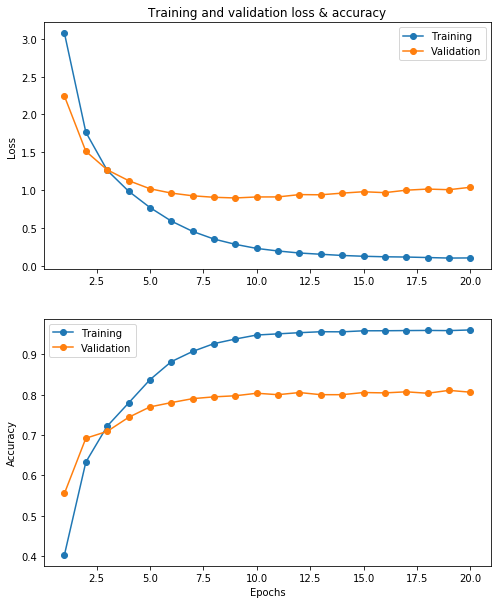

In [68]:
plot_history(history)

## Making predictions

Let's use the test set to make predictions on, and see the output of the softmax activation.

In [76]:
preds = model.predict(test_x)
print('Predictions over 46 classes:', preds[0])
print('Index of max prediction:', np.argmax(preds[0]))

Predictions over 46 classes: [9.79531906e-04 1.06287487e-02 2.29966524e-03 5.00742253e-03
 9.23584402e-03 1.28975417e-03 2.33916544e-05 2.63494643e-04
 6.55866275e-03 4.02035657e-03 7.34615605e-04 3.90015449e-03
 4.38539824e-03 9.73650749e-05 4.31407272e-04 6.37970879e-05
 5.00482786e-03 1.10105415e-04 9.02081607e-04 7.90834665e-01
 9.50786620e-02 3.59312096e-03 1.33897818e-03 8.56749830e-05
 1.94109965e-03 7.99287693e-04 1.96999754e-04 7.24641467e-03
 1.54811030e-04 9.02166311e-03 5.71119162e-05 2.53240869e-04
 1.10586123e-04 1.28454019e-04 1.11214467e-03 1.21456664e-03
 3.36516346e-03 6.39775360e-04 2.40261829e-03 5.78154504e-05
 2.36450098e-02 1.27528561e-04 1.78641538e-04 1.45793936e-04
 5.25872238e-05 2.81019951e-04]
Index of max prediction: 19


## Experiment 1: Encode labels as integer tensors

What if we didn't encode output labels into one-hot representations, and instead use them as integer values?
- Yes keras has a way to make this work, the only thing that needs to be changed in the model above is the loss function to `sparse_categorical_crossentropy`. This will do pretty much the same thing as one-hot encoding the labels - keras will expand the 1D values into 46D automatically so you should keep the number of nodes to 46 in the output layer.

Does it become a regression problem having a ?
- No, although having a single output node with values in the range [0,45] is leading in that direction. To convert this into a regression problem (although I don't see a reason how this could benefit the proejct of predicting newswires - apart from learning) we can do the following changes:
    - Set a single node in the output layer of the model with 'linear' activation
    - Change the loss function to a regression loss function, such as Mean Squared Error (mse)
    - Optionally change the metric from 'accuracy' to a regression related metric. I'm not sure what 'accuracy' would measure in a regression problem (?)

In [13]:
train_y_ints = np.array(train_labels)
test_y_ints = np.array(test_labels2)
dev_y_ints = np.array(dev_labels)

In [22]:
# Create the same model but with one output node
def create_model_ints():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    return model
model_ints = create_model_ints()

# Compile and train the new model
model_ints.compile(optimizer='adam', loss='mse')
history = model_ints.fit(train_x, train_y_ints, epochs=20, batch_size=512, validation_data=(dev_x, dev_y_ints))

Train on 8982 samples, validate on 1123 samples
Epoch 1/20
8982/8982 [==============================] - 2s 202us/step - loss: 124.9850 - val_loss: 89.6299
Epoch 2/20
8982/8982 [==============================] - 1s 130us/step - loss: 85.3073 - val_loss: 77.7237
Epoch 3/20
8982/8982 [==============================] - 1s 125us/step - loss: 67.6531 - val_loss: 62.1418
Epoch 4/20
8982/8982 [==============================] - 1s 130us/step - loss: 49.5407 - val_loss: 48.5982
Epoch 5/20
8982/8982 [==============================] - 1s 126us/step - loss: 36.6707 - val_loss: 42.4587
Epoch 6/20
8982/8982 [==============================] - 1s 126us/step - loss: 29.1160 - val_loss: 39.6926
Epoch 7/20
8982/8982 [==============================] - 1s 127us/step - loss: 23.5870 - val_loss: 37.5561
Epoch 8/20
8982/8982 [==============================] - 2s 172us/step - loss: 19.2034 - val_loss: 36.5163
Epoch 9/20
8982/8982 [==============================] - 1s 137us/step - loss: 15.9739 - val_loss: 36.67

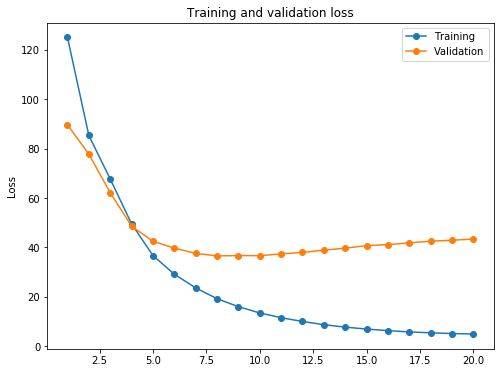

In [35]:
plot_history(history)

## Experiment 2: Having a bottleneck layer

As the author in the 'Deep Learning With Python' book suggests, where this example comes from, an intermediate layer having substantially less nodes than the output one (46) would drop information, resulting in a lower performance. Let's try using a hidden layer with only a few nodes and see.

In [37]:
# Create a model with a bottleneck layer
model_bottleneck = models.Sequential()
model_bottleneck.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_bottleneck.add(layers.Dense(4, activation='relu'))
model_bottleneck.add(layers.Dense(46, activation='softmax'))

# Compile and train the new model
model_bottleneck.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_bottleneck = model_bottleneck.fit(train_x, train_y, epochs=20, batch_size=512, validation_data=(dev_x, dev_y))

Train on 8982 samples, validate on 1123 samples
Epoch 1/20
8982/8982 [==============================] - 2s 178us/step - loss: 3.6635 - acc: 0.2555 - val_loss: 3.3949 - val_acc: 0.3749
Epoch 2/20
8982/8982 [==============================] - 1s 138us/step - loss: 3.1857 - acc: 0.3681 - val_loss: 2.9213 - val_acc: 0.3998
Epoch 3/20
8982/8982 [==============================] - 1s 145us/step - loss: 2.7114 - acc: 0.3988 - val_loss: 2.5001 - val_acc: 0.4248
Epoch 4/20
8982/8982 [==============================] - 1s 151us/step - loss: 2.3064 - acc: 0.4138 - val_loss: 2.1848 - val_acc: 0.4559
Epoch 5/20
8982/8982 [==============================] - 1s 141us/step - loss: 2.0020 - acc: 0.4991 - val_loss: 1.9551 - val_acc: 0.5441
Epoch 6/20
8982/8982 [==============================] - 1s 145us/step - loss: 1.7669 - acc: 0.5855 - val_loss: 1.7986 - val_acc: 0.5770
Epoch 7/20
8982/8982 [==============================] - 1s 153us/step - loss: 1.6007 - acc: 0.5838 - val_loss: 1.6946 - val_acc: 0.5726


Anyway, it's amazing how this bottleneck layer with very few nodes still manages to keep most of the information. The above bottleneck model had only 10% absolute drop in accuracy, compared to the original model. I'm sure this idea is used in autoencoders where a neural network with a bottleneck layer is trained in order to learn a lower-dimensional representation of the data. Does PCA work on a similar idea?